# Gaussian Discriminant Analysis
## Importing and Splitting
I split the dataset into a 30-70 test-train split.

In [1]:
from sklearn import datasets
iris = datasets.load_iris(as_frame=True)

In [2]:
import pandas as pd
data = iris["frame"]
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
# Randomly split 30-70 test-train
import numpy as np

indices = np.arange(len(data))
np.random.shuffle(indices)

split = int(0.7 * len(data)) 
train_idx, test_idx = indices[:split], indices[split:]

train, test = data.iloc[train_idx], data.iloc[test_idx]

## Visualization
I then plotted the different classes across two feature dimensions, the sepal length and petal length.

In [5]:
class0 = train[train["target"] == 0]
class1 = train[train["target"] == 1]
class2 = train[train["target"] == 2]
x_class0 = class0["sepal length (cm)"]
y_class0 = class0["petal length (cm)"]
x_class1 = class1["sepal length (cm)"]
y_class1 = class1["petal length (cm)"]
x_class2 = class2["sepal length (cm)"]
y_class2 = class2["petal length (cm)"]

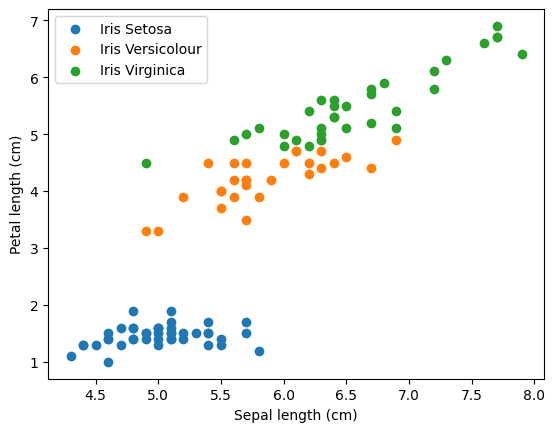

In [57]:
import matplotlib.pyplot as plt

plt.scatter(x_class0, y_class0, label="Iris Setosa")
plt.scatter(x_class1, y_class1, label="Iris Versicolour")
plt.scatter(x_class2, y_class2, label="Iris Virginica")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.legend()
plt.show()


### Pattern discussion
As seen, there is some visual clustering of the three different classes from eachother. We can see the best separation between the Iris Setosa and the other two flower types. This is seen by a lower mean sepal and petal length in Iris Setosa.

Interestingly, across all flower types, there is larger variance in the sepal length than the petal length (the clusters are longer horizontally).

Lastly, there seems to be some positive covariance in the sepal length and petal length, but only for the Iris Versicolour and Iris Virginica flower types. We see this through the diagonally slanted data distribution. Interestingly, the Iris Setosa shows no covariance with these dimensions.

## Recovering and printing prior probabilities
I calculated the proportion of observations for each class over all the observations in the training set. Interestingly it deviates significantly from the original 33% in the presplit dataset with both the training and testing data.

In [35]:
class0_size = class0.shape[0]
class1_size = class1.shape[0]
class2_size = class2.shape[0]
total = class0_size + class1_size + class2_size
phis = [class0_size/total, class1_size/total, class2_size/total]
print(f"The probability of class 0: {phis[0]}")
print(f"The probability of class 1: {phis[1]}")
print(f"The probability of class 2: {phis[2]}")
phis = np.array(phis)

The probability of class 0: 0.4095238095238095
The probability of class 1: 0.2761904761904762
The probability of class 2: 0.3142857142857143


## Computing multivariate Gaussian means and covariance matrices
I computed the empirical mean and covariance matrix for each class k, assuming that each class distribution was one multivariate Gaussian.

In [63]:
import numpy as np
# Code adapted from HW3 code companion
X = train[["sepal length (cm)", "sepal width (cm)", "petal length (cm)",	"petal width (cm)"]]
d = 4 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])

# we now compute the parameters
for k in range(K):
    X_k = X[train["target"] == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X_k.T)

# print out the means
print("The columns are sepal length, sepal width, petal length, petal width")
print(f"I. Setosa means: {mus[0]}")
print(f"I. Versicolour means: {mus[1]}")
print(f"I. Virginica means: {mus[2]}")
print("I. Setosa covariance matrix:")
print(Sigmas[0])
print("I. Versicolour covariance matrix:")
print(Sigmas[1])
print("I. Virginica covariance matrix:")
print(Sigmas[2])

The columns are sepal length, sepal width, petal length, petal width
I. Setosa means: [5.00697674 3.45813953 1.46511628 0.25348837]
I. Versicolour means: [5.86206897 2.74482759 4.24137931 1.32413793]
I. Virginica means: [6.58484848 2.95757576 5.51212121 2.        ]
I. Setosa covariance matrix:
[[0.13114064 0.10696567 0.01548726 0.01199889]
 [0.10696567 0.15392027 0.01064784 0.00919712]
 [0.01548726 0.01064784 0.03184939 0.0069103 ]
 [0.01199889 0.00919712 0.0069103  0.01254707]]
I. Versicolour covariance matrix:
[[0.23100985 0.06390394 0.15948276 0.05059113]
 [0.06390394 0.08827586 0.06736453 0.02923645]
 [0.15948276 0.06736453 0.18536946 0.06289409]
 [0.05059113 0.02923645 0.06289409 0.03189655]]
I. Virginica covariance matrix:
[[0.46695076 0.12558712 0.38862689 0.055625  ]
 [0.12558712 0.13189394 0.0933428  0.050625  ]
 [0.38862689 0.0933428  0.40297348 0.0565625 ]
 [0.055625   0.050625   0.0565625  0.075     ]]


## Implement and run GDA to classify flowers
### Prediction
I used the parameters from the previous section to predict the class of the test set that was reserved in the first section.

In [37]:
test.head()
X = test.drop(["target"], axis=1)

In [39]:
# Return P(x|y)P(y) for given x
# Code adapted from HW3 code companion
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute argmax_y p(y|x) as argmax_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)
print(idx)

[2 2 2 2 0 2 2 1 1 1 0 0 1 2 1 2 2 2 1 2 1 2 2 1 2 1 2 0 1 2 1 2 0 1 2 0 1
 1 1 2 1 1 1 1 0]


/tmp/ipykernel_2540/3115108218.py:18: RuntimeWarning: overflow encountered in exp
  * -.5*np.exp(


### Evaluation
I used the F1 score to evaluate this prediction of the test set. The F1 score is a good choice for a classification task, because it appropriately considers both the precision and recall. The precision is a metric of how correct the positive predictions are for a class k (indicate how many negatives may have been inappropriately predicted positive. The recall is a metric of how complete the positive predicitons are for a class k (indicate how many positive may have been left out).

To combine the scores across multiple classes, I used the 'macro' average that considers the three flower classes equally. I thought this was appropriate, because the original dataset has an equal split of the three flower types. In addition, I have no a priori motivation to focus my model on distinguishing a specific flower type.

In [43]:
from sklearn.metrics import f1_score

y_true = test["target"]
print(f1_score(y_true, idx, average ='macro'))

0.9648148148148148


As seen, the model gives an F1 score of 0.9648 on the testing set which indicates that it is very good at predicting the flower type.

### K-means clustering
Intuitively, I thought that K-means clustering would create different clusters than the GDA algorithm. Here, I perform a K nearest neighhors algorithm with n_neighbors = 2.

In [54]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(train.drop(["target"],axis=1), train["target"])

,n_neighbors,2
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [55]:
KNN_preds = neigh.predict(X)

In [56]:
print(f1_score(y_true, KNN_preds, average ='macro'))

0.9648148148148148


As seen, the F1 score is exactly the same! This made me rethink my initial intuition and realize that the K-means clustering (is equivalent to the GDA algorithm performed here. This is because the GDA algorithm assumed that each flower type was represented by a single multivariate Gaussian distribution, not by their own mixture of Gaussians. Thus, for each flower type, the model complexity can only capture the dimension-weighted distance from the Gaussian mean. This is similar to the K-means algorithm that relies on distances to determine clustering.

However, an important note is that this only applies to a K-means clustering with three centroid (K=3) to match the number of Gaussian distributions in the GDA algorithm. A K-means clustering with two centroid (K=2) will not match the GDA algorithm. This is because two centroids can not match the model complexity of three Gaussians.

For K=2 K-means clustering, a common result would be that the Iris Virginica and Iris Versicolour become clustered together without distinction.